## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

%matplotlib inline

#We are setting the seed to assure we get the same answers
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, we'll read in the `ab_data.csv` data and store it in `df`.

a. Read the dataset and display top few rows:

In [2]:
# reads the csv file and creates a dataframe
df = pd.read_csv('ab_data.csv')

# display first few rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
# unique number of users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# total conversion rate
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df.group=='treatment') & (df.landing_page != 'new_page')].group.count()

1965

In [7]:
df[(df.group!='treatment') & (df.landing_page == 'new_page')].group.count()

1928

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. So we will remove those records.

a. We will create a new dataset with only the aligned records and store in new dataframe in **df2**.

In [9]:
# get only aligned records
df2 = df[((df.group=='treatment') & (df.landing_page == 'new_page')) |
         ((df.group=='control') & (df.landing_page == 'old_page'))]

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` We can see that we need to clean **df2** dataframe in order to achieve better results

a. How many unique **user_id**s are in **df2**?

In [12]:
# unique number of users
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# count of records for each user_id
usr = df2.groupby('user_id').user_id.count()

In [14]:
usr[usr>1]

user_id
773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id==usr[usr>1].index[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [16]:
# drop record in index 1899
df2.drop([1899],inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
df2[df2.user_id==usr[usr>1].index[0]]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Now that our data is pretty clean, we will begin probability calculation using **df2**:

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
# total conversion rate
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# get control group data
control_df = df2.query('group=="control"')

# get treatment group data
treatment_df = df2.query('group=="treatment"')

In [21]:
control_df.shape

(145274, 5)

In [22]:
treatment_df.shape

(145310, 5)

In [23]:
# conversion rate of control group
control_rate = control_df.converted.mean()

control_rate

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
# conversion rate of treatment group
treatment_rate = treatment_df.converted.mean()

treatment_rate

0.11880806551510564

d. What is the probability that an individual received the new page?

In [25]:
# chance that an individual will receive new page
df2[df2.landing_page == 'new_page'].group.count()/df2.group.count()

0.50006194422266881

In [26]:
# difference in conversion rate between two groups
obs_diff = treatment_rate - control_rate

obs_diff

-0.0015782389853555567

e. Is there evidence that one page leads to more conversions?

The probability of receiving a new page ~ 0.5. Seems there is equal probability of receiving an **old_page** or a **new_page**.

Conversion rate of old_page = 0.1203863045004612

Conversion rate of new_page = 0.11880806551510564

The difference in conversion rates = -0.0015782389853555567

**Negative difference shows old_page is better than new_page. But the difference is not very significant**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  Let us assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? hypothesis are given in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0 : $p_{old}$ $\geq$ $p_{new}$**<br>
**H1 : $p_{old}$ $\lt$ $p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then we will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [27]:
# total conversion rate
p_new_null = df2.converted.mean()
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? 

In [28]:
# total conversion rate
p_old_null = df2.converted.mean()
p_old_null

0.11959708724499628

c. What is $n_{new}$?

In [29]:
# number of users in treatment group
n_new = treatment_df.shape[0]
n_new

145310

d. What is $n_{old}$?

In [30]:
# number of users in control group
n_old = control_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
# simulate 1s amd 0s using treatment group data
new_page_converted = np.random.choice(2,n_new,p=[p_new_null,1-p_new_null])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
# simulate 1s amd 0s using control group data
old_page_converted = np.random.choice(2,n_old,p=[p_old_null,1-p_old_null])

g.  $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [33]:
# conversion rate in simulated treatment group data
p_new = new_page_converted.mean()
p_new

0.88088913357649168

In [34]:
# conversion rate in simulated control group data
p_old = old_page_converted.mean()
p_old

0.88149978661012984

In [35]:
# difference in conversion rate between two groups
p_new - p_old

-0.00061065303363816437

h. We will simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process as above and store all 10,000 values in **p_diffs**.

In [36]:
p_diffs = []

# loop for 10000 runs
for _ in range(10000):
    
    # simulate control group and get conversion rate
    p_old = (np.random.choice(2,n_new,p=[p_new_null,1-p_new_null])).mean()
    
    # simulate treatment group and get conversion rate
    p_new = (np.random.choice(2,n_old,p=[p_old_null,1-p_old_null])).mean()
    
    # difference in converion rate
    p_diffs.append(p_new - p_old)

In [37]:
# convert into numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

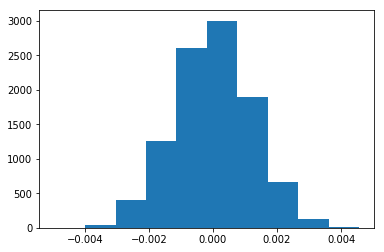

In [38]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

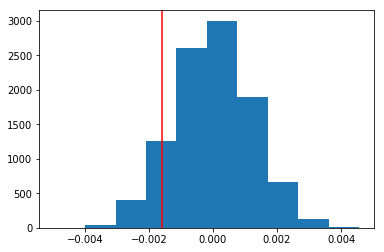

In [39]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff,color='red');

In [40]:
(p_diffs > obs_diff).mean()

0.90580000000000005

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**<br> This value is called the **p-value**. It is the probability of observing our statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.


The **p-value** = **0.9030** which is significantly greater than 0.05 at 5% Type I error rate. This means there is more probability that our observed statistic is from the null.

Hence **we fail to reject the NULL HYPOTHESIS**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [41]:
# number of conversion in control group
convert_old = control_df.converted.sum()

# number of conversion in treatment group
convert_new = treatment_df.converted.sum()

m. Now we will use `stats.proportions_ztest` to compute our test statistic and p-value.

In [42]:
# perform z-test on data
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],\
                                              #n_old,n_new are number of users in control and treatment groups respectively
                                              [n_old, n_new])

In [43]:
z_score

1.3109241984234394

In [44]:
p_value

0.18988337448195103

In [45]:
# Tells us how significant our z-score is
norm.cdf(z_score)

0.90505831275902449

In [46]:
# Tells us what our critical value at 95% confidence is
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**<br> z_score = 1.311 <br> critical_value = 1.96 <br>Since z_score is less than the critical value, **we fail to reject the NULL HYPOTHESIS**

This results in the same outcome as previous findings.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result from the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  We will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
# create dummy variable for group and add column in dataframe
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']

# add column for intercept
df2['intercept'] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [49]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. We'll use **statsmodels** to import our regression model, Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [50]:
# perform Logistic Regression
lm = sm.Logit(df2.converted,df2[['intercept','ab_page']])

# fit the model
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of our model fit

In [51]:
# regression model summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        07:24:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?

**Answer**<br> p-value =  0.190 (for ab_page from regression model) <br> p-value = 0.1898 (from z-test) <br> p-value = 0.9030 (from hypothesis test)<br><br> The value from hypothesis test is different from regression and z-test because of the NULL & ALTERNATIVE hypothesis considered.

In Hypothesis test:<br>
H0: $p_{old}$ $\geq$ $p_{new}$ <br> H1: $p_{old}$ $\lt$ $p_{new}$

In z-test, regression:<br>
H0: $p_{old}$ = $p_{new}$ <br> H1: $p_{old}$ $\neq$ $p_{new}$

Because of this difference we have a different p-value.

From z-test and regression, since p-value > 0.05, we can **reject the NULL HYPOTHESIS**.<br>Therefore $p_{new}$ $\neq$ $p_{old}$

f. Now, we are considering other things that might influence whether or not an individual converts.  Is it a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

**Answer**<br> There are advantages and disadvantages in considering other things that might influence the conversion.

**Advantages:**<br>
1. Improves accuracy of result<br>
2. Provides better prediction<br>

**Disadvantages:**<br>
1. Linear relationship does not exist<br>
2. Correlated errors<br>
3. Non-Constant variance<br>
4. Outliers<br>
5. Multicollinearity<br>

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?

In [52]:
# read countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [53]:
# merge dataset on user_id column
df2 = df2.merge(countries_df,on = 'user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [54]:
# unique contry values
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [55]:
# create dummy variables for country
df2[['CA','UK','US']] = pd.get_dummies(df2.country)

In [56]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [57]:
# perform Logistic Regression
lm = sm.Logit(df2.converted,df2[['intercept','ab_page','CA','UK']])

# fit the model
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [58]:
# regression model summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               2.323e-05
Time:                        07:24:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Result:**<br>p-value = 0.191 (ab_page)<br>p-value = 0.130 (CA)<br>p-value = 0.457 (UK)

Hypothesis:<br>H0: $p_{old}$ = $p_{new}$ <br> H1: $p_{old}$ $\neq$ $p_{new}$<br><br>All the above p-values are >0.05 at 95% confidence. Hence **we reject the NULL HYPOTHESIS**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [59]:
# interaction between page and country UK
df2['UK_and_page'] = df2['UK']*df2['ab_page']

# interaction between page and country US
df2['US_and_page'] = df2['US']*df2['ab_page']

# interaction between page and country CA
df2['CA_and_page'] = df2['CA']*df2['ab_page']

In [60]:
# perform Logistic Regression
lm = sm.Logit(df2.converted,df2[['intercept','ab_page','UK','CA','UK_and_page','CA_and_page']])

# fit the model
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [61]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        07:24:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_and_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_and_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
===============================================================================
"""

**Result:**<br>
p-value = 0.132 (ab_page)<br>
p-value = 0.642 (CA)<br>
p-value = 0.383 (CA_and_page)<br>
p-value = 0.760 (UK)<br>
p-value = 0.238 (UK_and_page)<br>


Hypothesis:<br>
H0: $p_{old}$ = $p_{new}$<br>
H1: $p_{old}$ $\neq$ $p_{new}$

All the above p-values are >0.05 at 95% confidence. Hence **we reject the NULL HYPOTHESIS**

The result is the same as previous outcome for logistic regression without the interaction terms.<br><br>The Pseudo R-square value without interaction terms is - **0.00002323**<br>The Pseudo R-square value with interaction terms is - **0.00003482**<br><br>We can see that the difference is not very significant. Hence this is not an improvement over the previous model

**VIF - Variance Inflation Factor**<br> The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression.It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone

In [62]:
# get y and X dataframes based on this regression
y, X = dmatrices('converted ~ ab_page + CA + US', df2, return_type='dataframe')

In [63]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [64]:
# summary
vif

,VIF Factor,features
0,5.002944,Intercept
1,1.000006,ab_page
2,1.140206,CA
3,1.140205,US


In [65]:
# get y and X dataframes based on this regression
y, X = dmatrices('converted ~ ab_page + CA + UK', df2, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [66]:
# summary
vif

,VIF Factor,features
0,2.428940,Intercept
1,1.000006,ab_page
2,1.017759,CA
3,1.017761,UK


In [67]:
# get y and X dataframes based on this regression
y, X = dmatrices('converted ~ ab_page + US + UK', df2, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [68]:
# summary
vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,ab_page
2,4.502223,US
3,4.502236,UK


**Result**<br>In all of the above VIF summary, we can see that the VIF-factor is < 10. Hence we can consider that there is less multicollinearity in the dataset. In other words, the conversion rate will remain the same irrespective of country.

<a id='conclusions'></a>
## Conclusion

> **Result**: From the above A/B testing, we have the following observations.<br><br> 1. Conversion rate of old page is not equal to Conversion rate of new page.<br> 2. Conversion rate of old page is better than new page.<br><br>Hence, It is better to stay with the old page

In [71]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0